# Deep Learning Model Comparison: Custom CNNs vs Transfer Learning

**Project Overview:**
- **What we are doing:** We are implementing a comprehensive deep learning project that compares two fundamental approaches for image classification using the CIFAR-10 dataset, which contains 60,000 32×32 color images across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

**Topics Covered:**
- **Topic 1 - Deep Learning Model Selection:** Building multiple custom CNN architectures from scratch with varying complexity levels (shallow, medium, and deep networks) to understand how architectural choices like depth, batch normalization, and dropout affect model performance and learning patterns.
- **Topic 2 - Transfer Learning Model Selection:** Leveraging pre-trained models (such as ResNet50 trained on ImageNet) and adapting them for CIFAR-10 classification through fine-tuning techniques, comparing different transfer learning strategies and pre-trained architectures.

**What is happening in each topic:**
- **Topic 1 process:** Design and train multiple CNN architectures with different depths and complexities, evaluate their performance using validation metrics, analyze training curves, and select the best performing custom model based on accuracy, loss, and generalization capability.
- **Topic 2 process:** Load pre-trained models, freeze initial layers to preserve learned features, add custom classification heads, fine-tune the models on CIFAR-10 data, and compare different transfer learning approaches to identify the most effective strategy.

**Our Goals:**
- **Performance comparison:** Determine which approach (custom CNNs vs transfer learning) achieves better accuracy and generalization on CIFAR-10 image classification.
- **Efficiency analysis:** Compare training time, computational requirements, and convergence speed between building models from scratch versus using pre-trained architectures.
- **Practical insights:** Understand when to choose custom CNN development over transfer learning based on factors like dataset size, computational resources, and specific task requirements.
- **Model selection mastery:** Demonstrate systematic model selection within each approach before making the final architectural decision between custom and transfer learning strategies.


#### Import Libraries

In [1]:
# Core libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import base64
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU available: []


#### Notebook utility

In [20]:
image_paths = ["cnn1.webp","cnn2.png","cnn3.webp","transferle1.png","transferle2.png","transferle3.webp","transferle4.webp"]
image_size = [700]*7
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("./img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


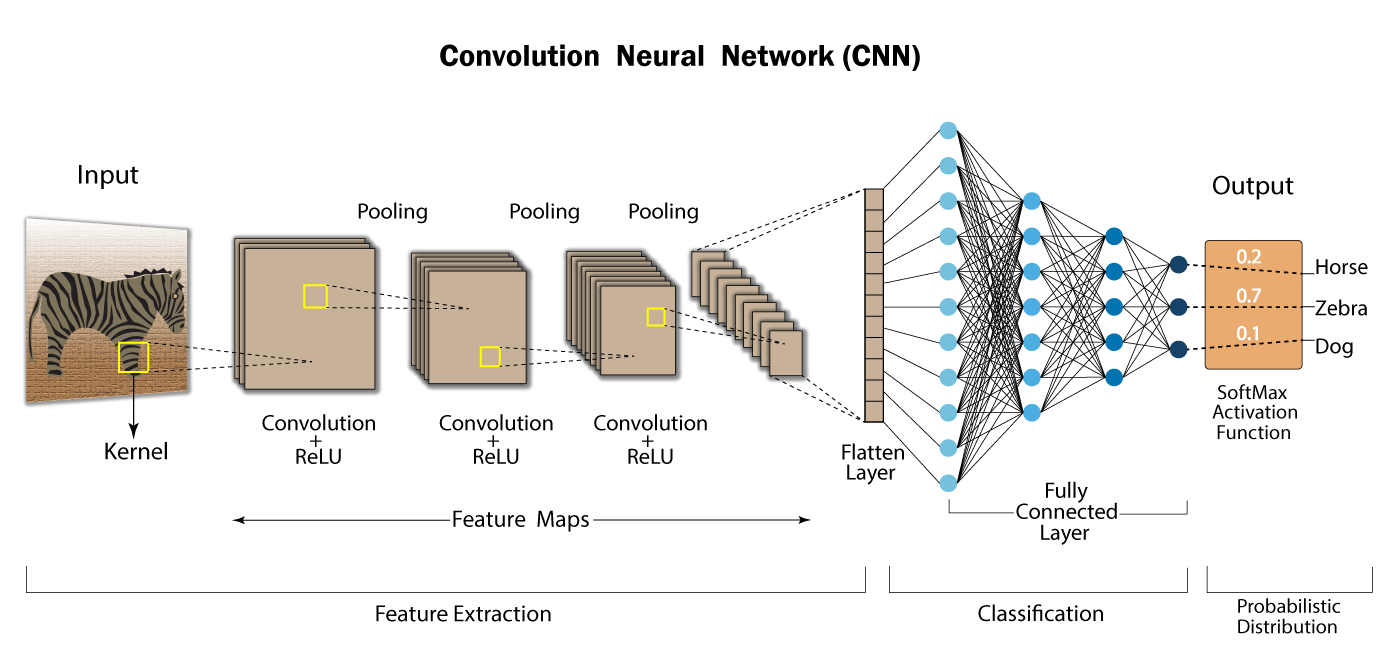

In [10]:
display(HTML(images_html[0]))


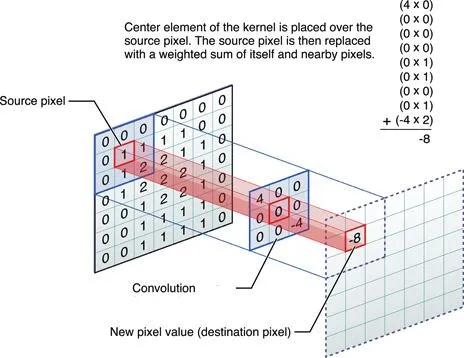

In [21]:
display(HTML(images_html[2]))


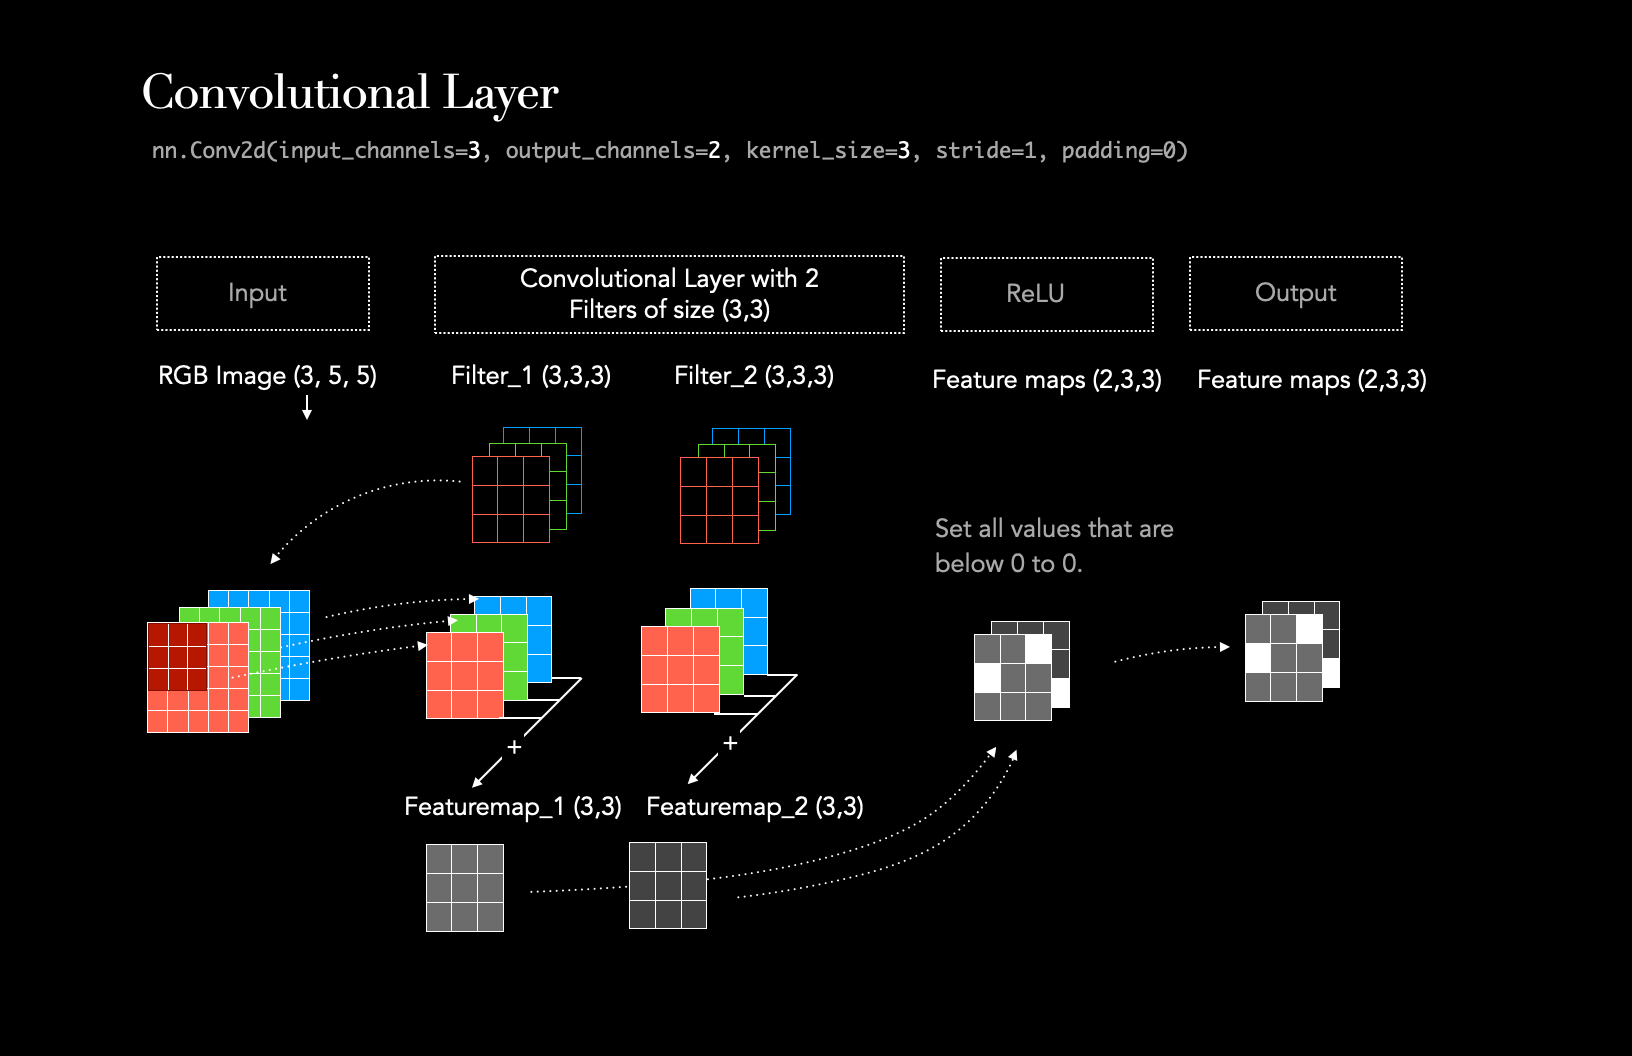

In [11]:
display(HTML(images_html[1]))


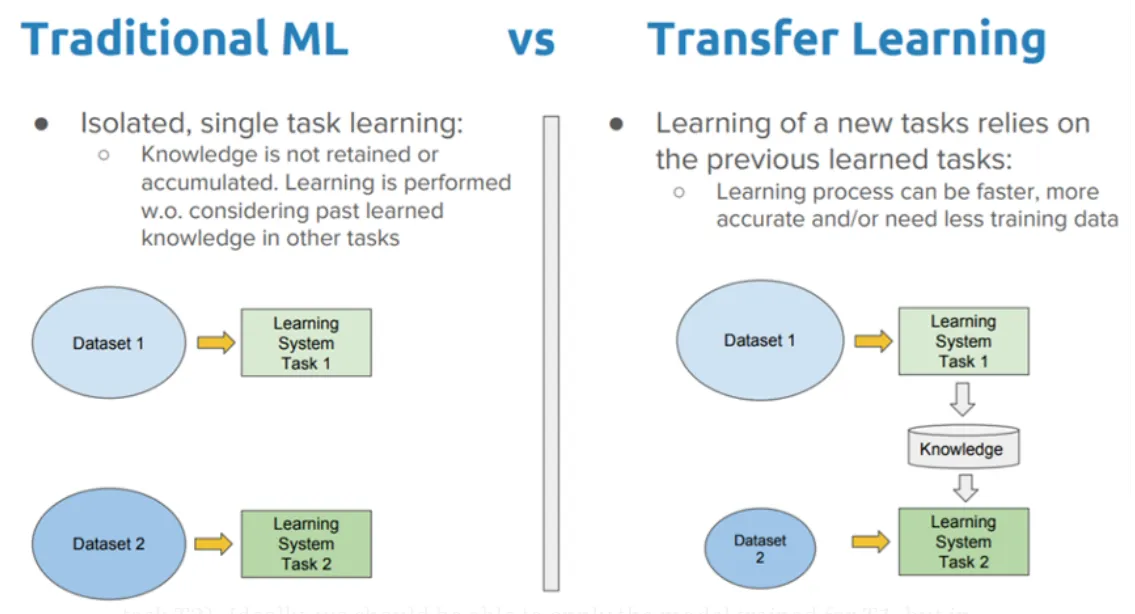

In [16]:
display(HTML(images_html[4]))


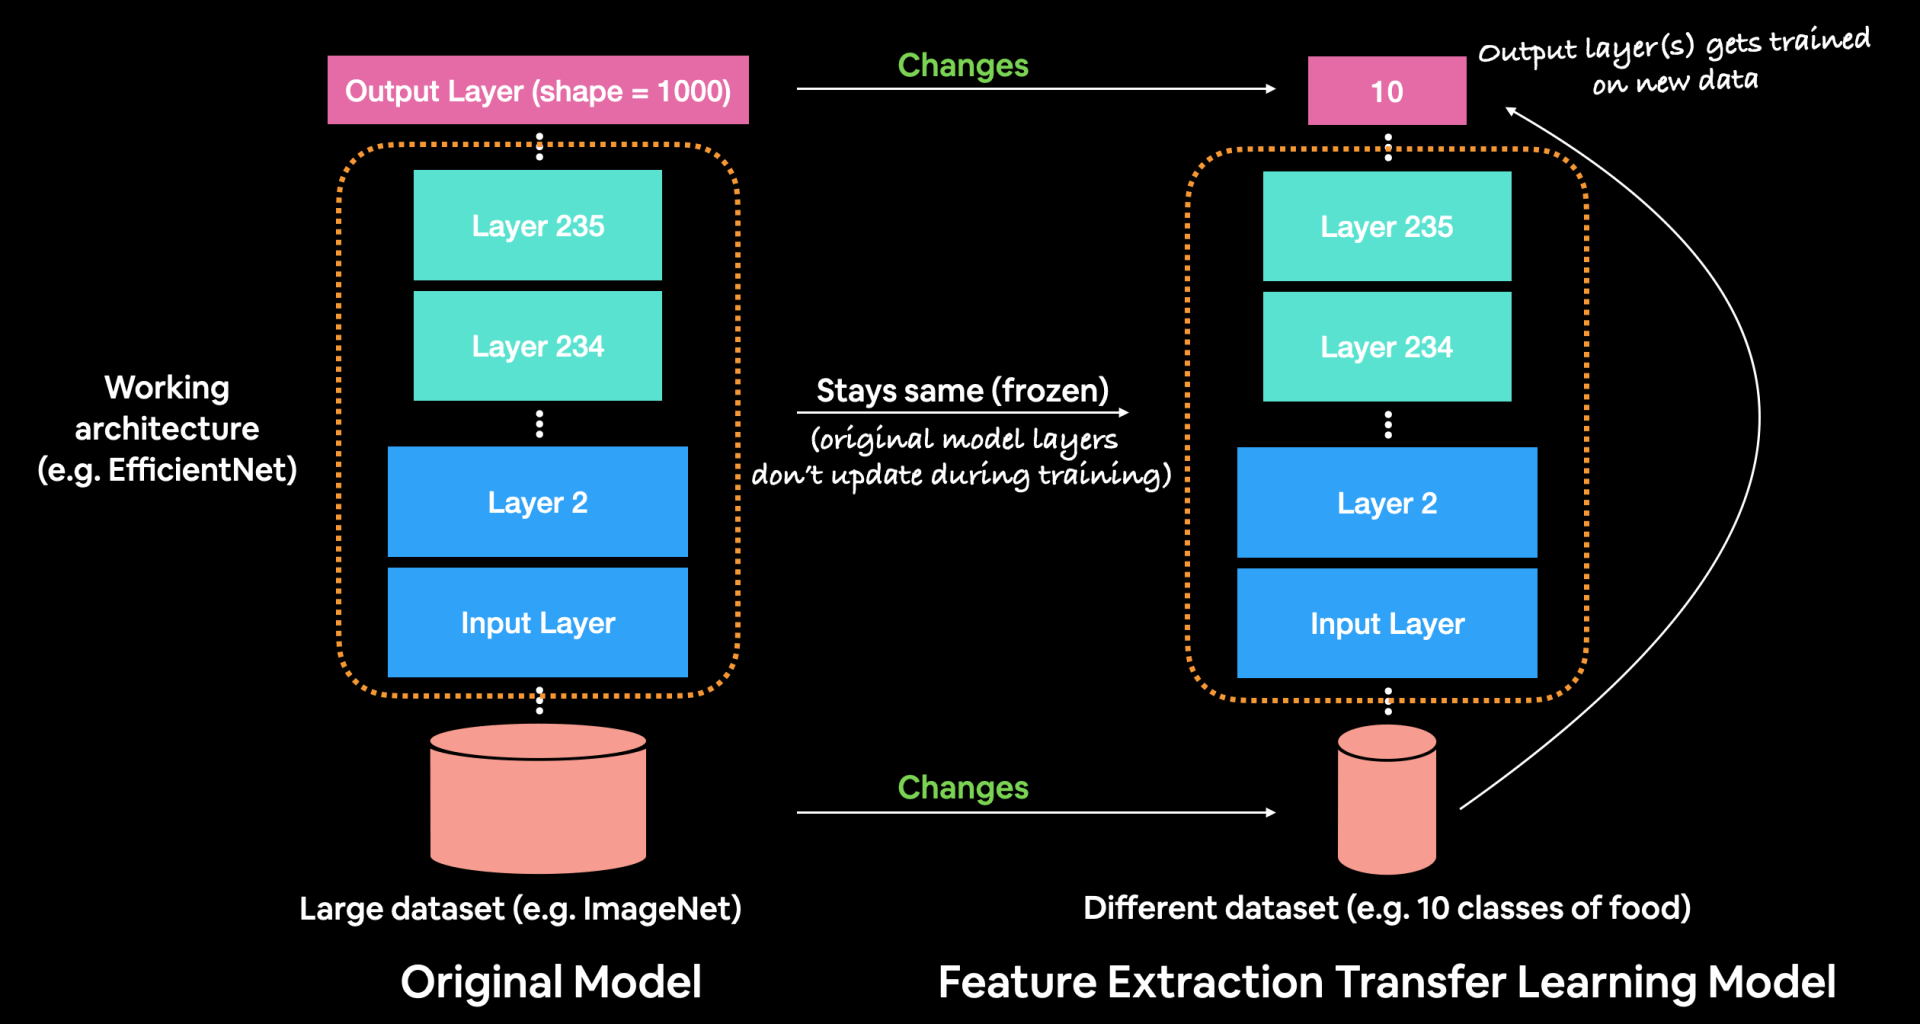

In [17]:
display(HTML(images_html[2]))


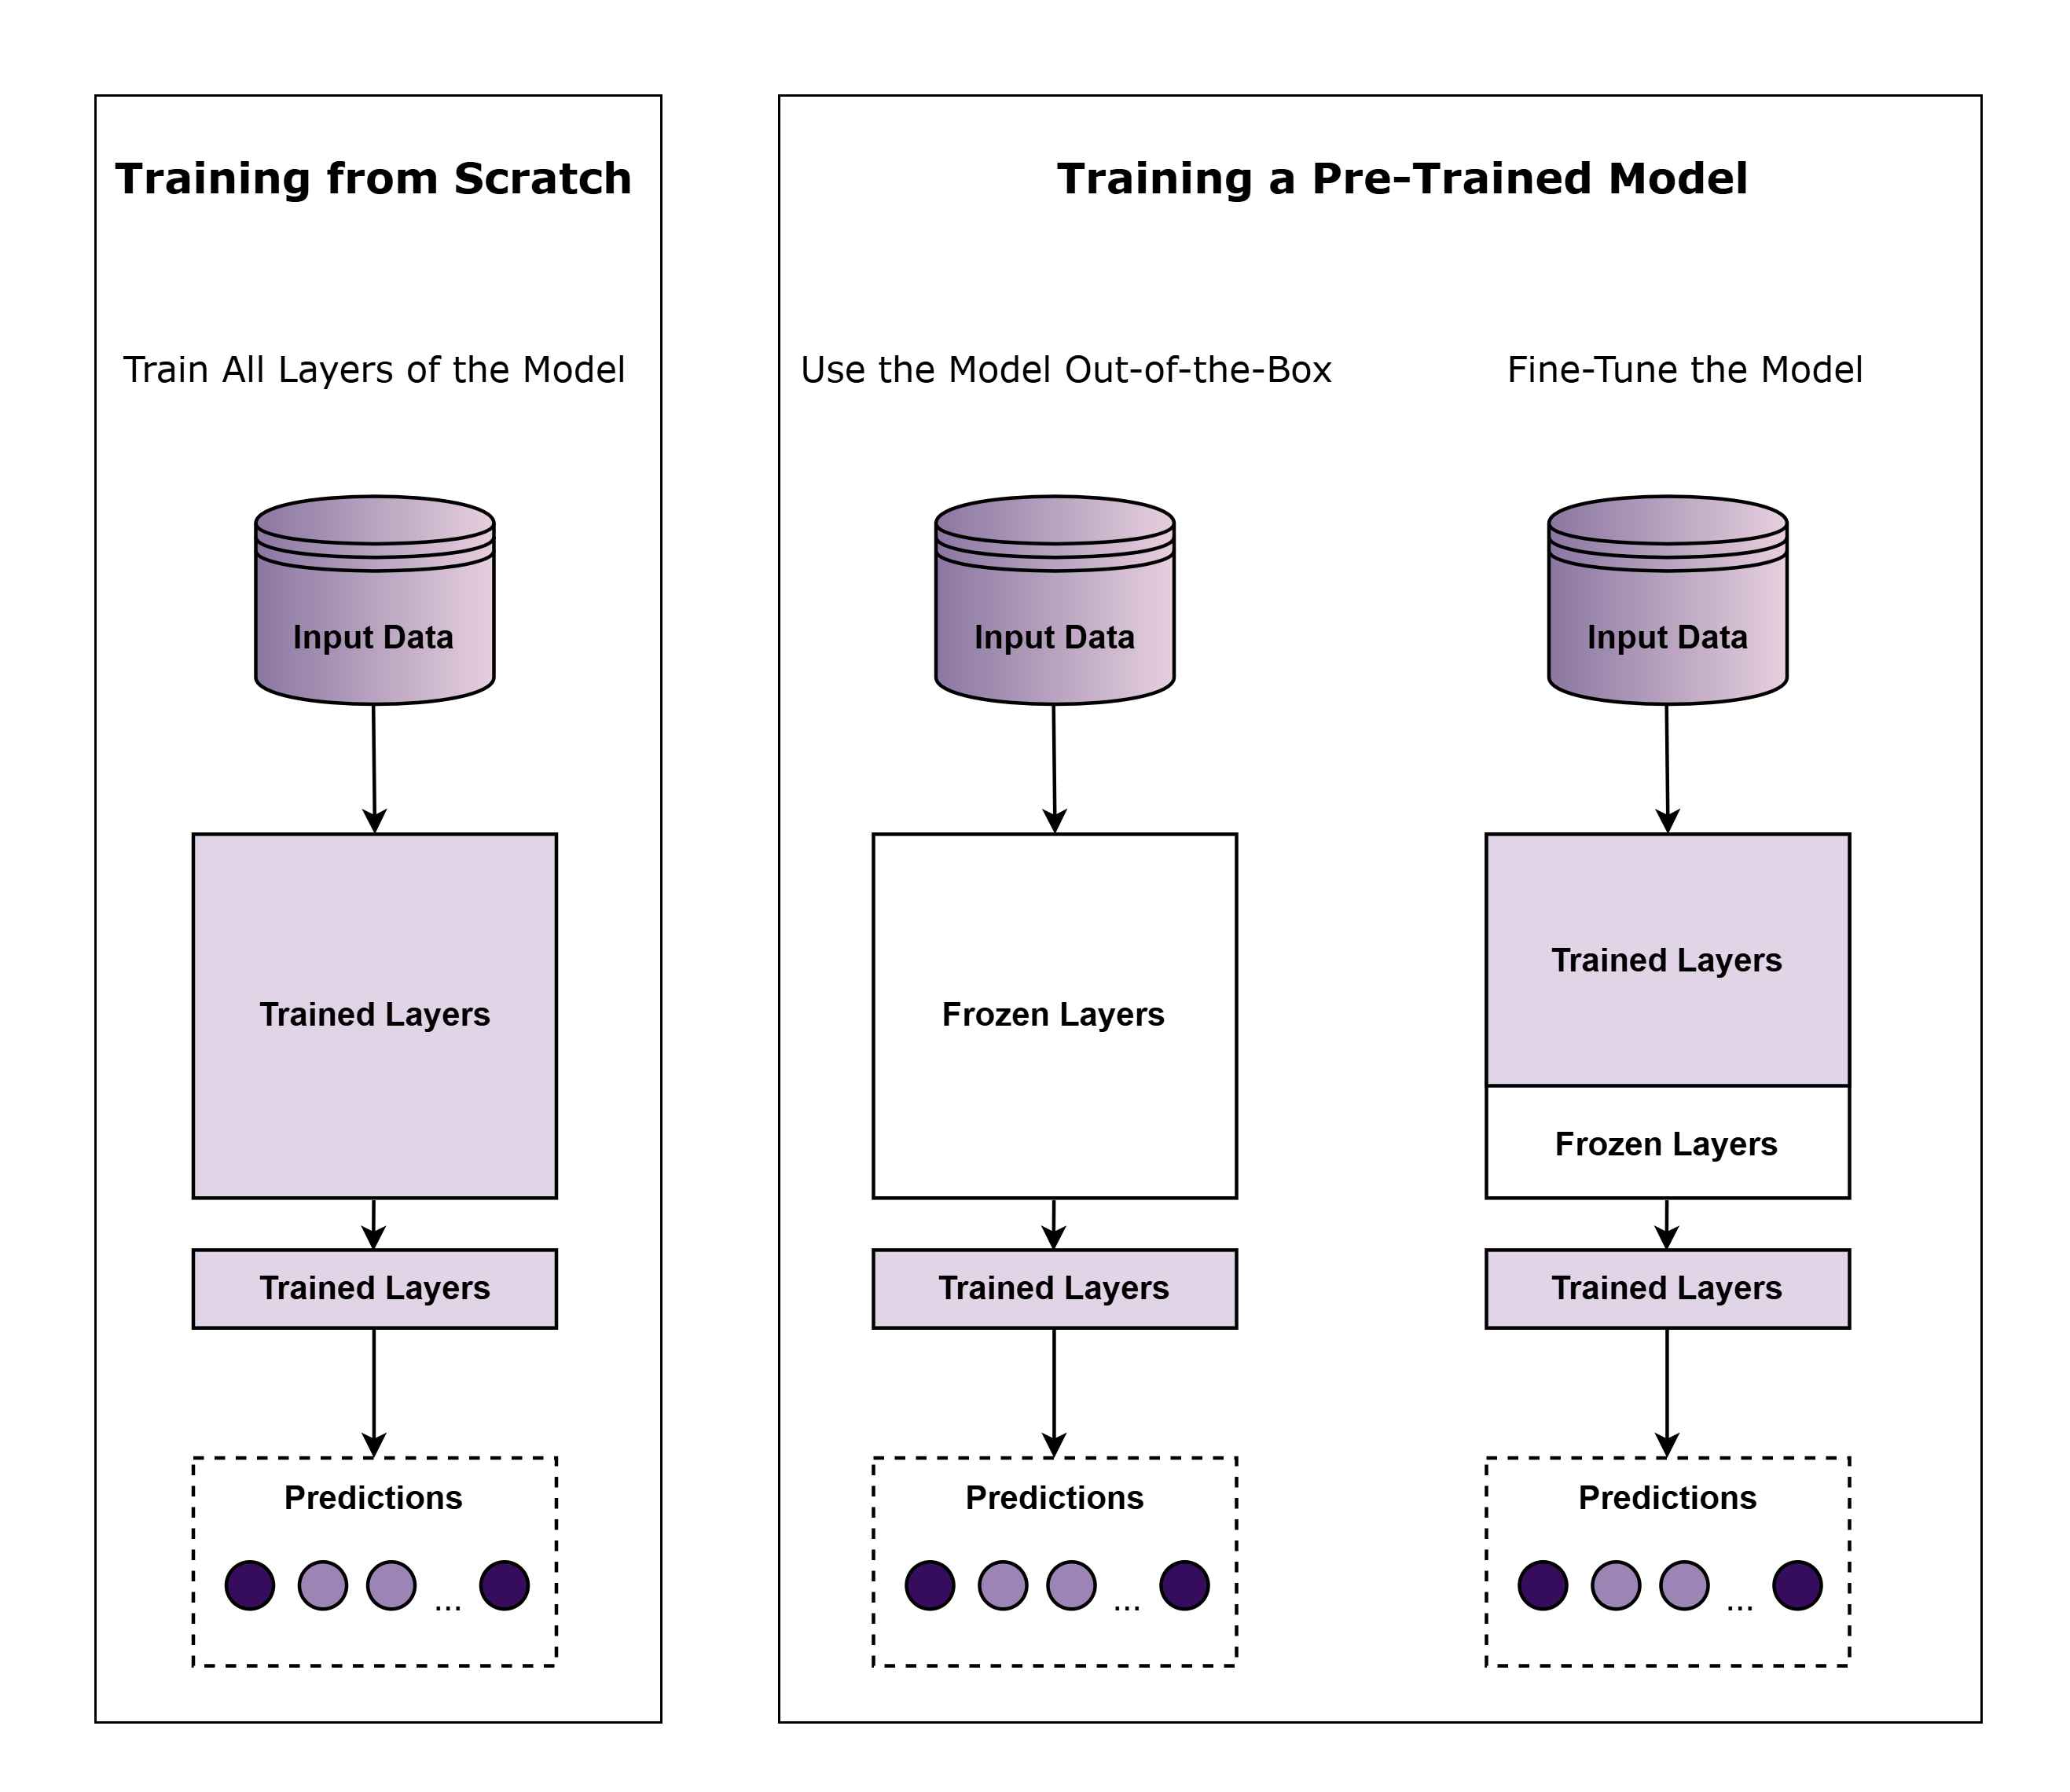

In [18]:
display(HTML(images_html[3]))


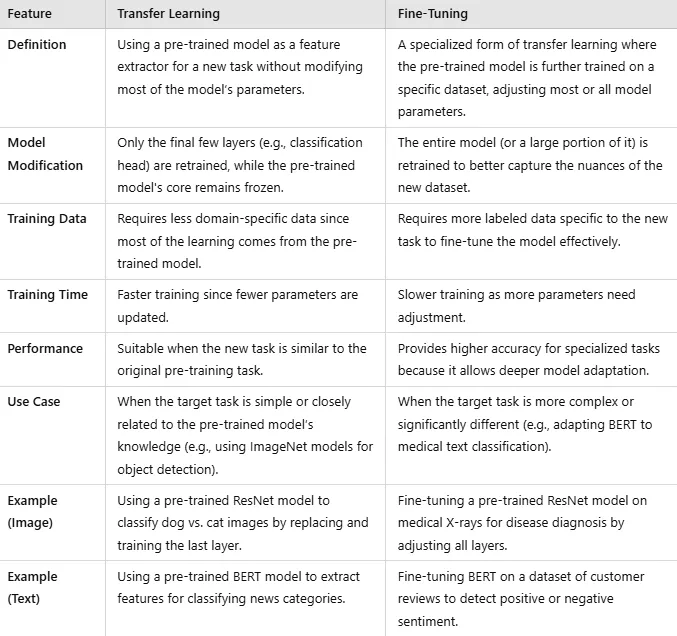

In [15]:
display(HTML(images_html[5]))

#### Load and Preprocess Dataset


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

# Create validation split from training data
validation_split = 0.2
val_samples = int(len(x_train) * validation_split)

x_val = x_train[:val_samples]
y_val = y_train_categorical[:val_samples]
x_train_split = x_train[val_samples:]
y_train_split = y_train_categorical[val_samples:]

print(f"Final training set: {x_train_split.shape}")
print(f"Validation set: {x_val.shape}")


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Final training set: (40000, 32, 32, 3)
Validation set: (10000, 32, 32, 3)


#### Some Common Utility Functions


In [3]:
def plot_training_history(history, title):
    """
    Plot training and validation accuracy and loss curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, x_test, y_test, y_test_categorical, model_name):
    """
    Evaluate model performance and display results
    """
    # Get predictions
    test_loss, test_accuracy = model.evaluate(x_test, y_test_categorical, verbose=0)
    predictions = model.predict(x_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print(f"\n{model_name} Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    return test_accuracy, predicted_classes

def create_confusion_matrix(y_true, y_pred, class_names, title):
    """
    Create and display confusion matrix
    """
    cm = confusion_matrix(y_true.flatten(), y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


## Topic 1: Custom CNN Architecture Comparison

We'll build three CNN models with different complexities to understand how architecture depth and design choices affect performance on CIFAR-10. This approach helps us learn the fundamentals of CNN design and the impact of various architectural decisions.

**Models to compare:**
1. **Shallow CNN**: Basic architecture with few layers
2. **Medium CNN**: Moderate depth with batch normalization
3. **Deep CNN**: Deeper architecture with dropout and advanced techniques


In [6]:
def create_shallow_cnn():
    """
    Simple CNN with basic convolutional and pooling layers
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_medium_cnn():
    """
    Medium complexity CNN with batch normalization
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

def create_deep_cnn():
    """
    Deeper CNN with dropout and more sophisticated architecture
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create all three models
shallow_model = create_shallow_cnn()
medium_model = create_medium_cnn()
deep_model = create_deep_cnn()

# Display model summaries
print("Shallow CNN Architecture:")
shallow_model.summary()
print("\nMedium CNN Architecture:")
medium_model.summary()
print("\nDeep CNN Architecture:")
deep_model.summary()


Shallow CNN Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)


Medium CNN Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,194 (1.10 MB)

 Trainable params: 288,746 (1.10 MB)

 Non-trainable params: 448 (1.75 KB)


Deep CNN Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,522 (1.24 MB)

 Trainable params: 323,562 (1.23 MB)

 Non-trainable params: 960 (3.75 KB)

#### Train and Evaluate Custom Models


Training Shallow CNN...
Epoch 1/20
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3265 - loss: 1.8188 - val_accuracy: 0.5247 - val_loss: 1.3076
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3265 - loss: 1.8188 - val_accuracy: 0.5247 - val_loss: 1.3076
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5413 - loss: 1.2919 - val_accuracy: 0.5905 - val_loss: 1.1257
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5413 - loss: 1.2919 - val_accuracy: 0.5905 - val_loss: 1.1257
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6109 - loss: 1.1094 - val_accuracy: 0.6299 - val_loss: 1.0384
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6109 - loss: 1.1094 - val_accuracy: 0.6299 - val_loss: 1.0384
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6559 - loss: 0.9931 - val_accuracy: 0.6576 - val_loss: 0.9747
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step 

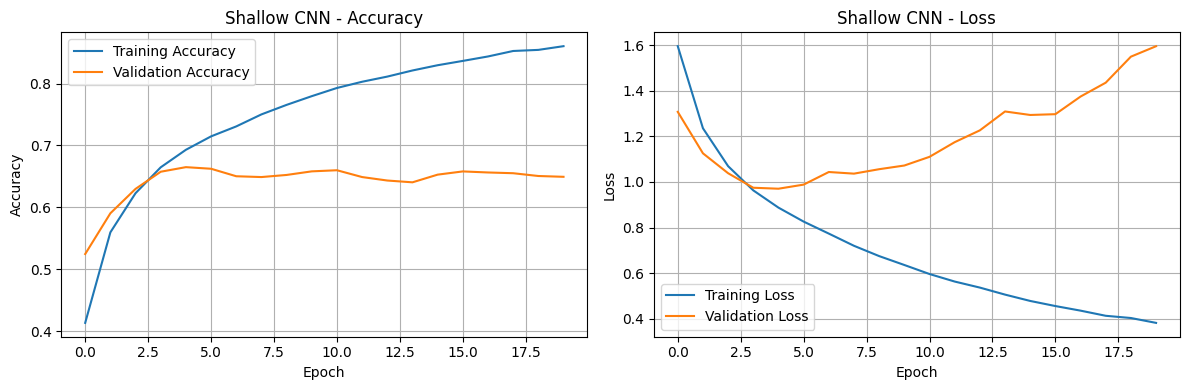


Training Medium CNN...
Epoch 1/20
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4273 - loss: 1.6571 - val_accuracy: 0.5269 - val_loss: 1.4418
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.4273 - loss: 1.6571 - val_accuracy: 0.5269 - val_loss: 1.4418
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6434 - loss: 1.0058 - val_accuracy: 0.6081 - val_loss: 1.1809
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6434 - loss: 1.0058 - val_accuracy: 0.6081 - val_loss: 1.1809
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7151 - loss: 0.8048 - val_accuracy: 0.6805 - val_loss: 0.9778
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7151 - loss: 0.8048 - val_accuracy: 0.6805 - val_loss: 0.9778
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7625 - loss: 0.6771 - val_accuracy: 0.6602 - val_loss: 1.0544
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━

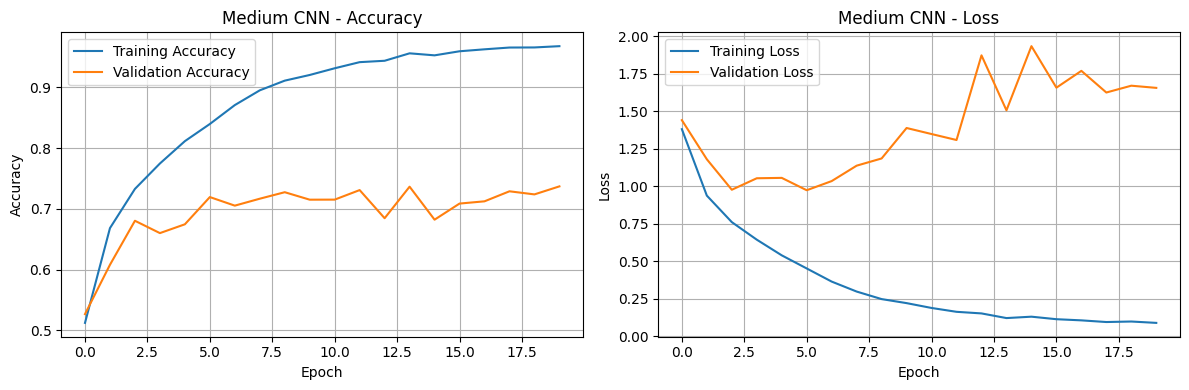


Training Deep CNN...
Epoch 1/20
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.2763 - loss: 2.2904 - val_accuracy: 0.5016 - val_loss: 1.3526
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.2763 - loss: 2.2904 - val_accuracy: 0.5016 - val_loss: 1.3526
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5203 - loss: 1.3378 - val_accuracy: 0.5277 - val_loss: 1.3517
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.5203 - loss: 1.3378 - val_accuracy: 0.5277 - val_loss: 1.3517
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6096 - loss: 1.1218 - val_accuracy: 0.6645 - val_loss: 0.9524
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6096 - loss: 1.1218 - val_accuracy: 0.6645 - val_loss: 0.9524
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.6530 - loss: 1.0011 - val_accuracy: 0.6766 - val_loss: 0.9359
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2

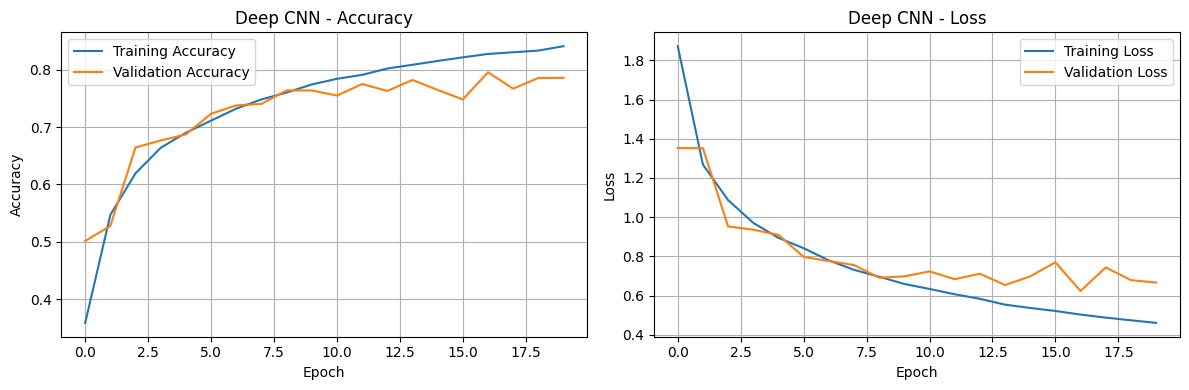

In [7]:
# Compile all models with same optimizer and loss function
models_dict = {
    'Shallow CNN': shallow_model,
    'Medium CNN': medium_model,
    'Deep CNN': deep_model
}

# Training parameters
epochs = 20
batch_size = 32

# Store results for comparison
custom_results = {}
custom_histories = {}

# Train each model
for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        x_train_split, y_train_split,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1
    )
    
    # Store results
    custom_histories[name] = history
    
    # Evaluate on test set
    test_acc, predictions = evaluate_model(model, x_test, y_test, y_test_categorical, name)
    custom_results[name] = {
        'test_accuracy': test_acc,
        'predictions': predictions,
        'model': model
    }
    
    # Plot training history
    plot_training_history(history, name)


#### Results: Custom CNN Models - Key Observations

**Performance Comparison:**
- The models show different learning patterns and final accuracies
- Deeper models may achieve higher accuracy but require more training time
- Batch normalization and dropout help with generalization and reduce overfitting

**Architecture Impact:**
- **Shallow CNN**: Fast training, may underfit complex patterns
- **Medium CNN**: Balanced approach with batch normalization
- **Deep CNN**: More parameters, potential for better feature learning but risk of overfitting


## Topic 2: Transfer Learning with Pre-trained Models

Transfer learning leverages models pre-trained on large datasets (like ImageNet) and adapts them for our CIFAR-10 task. This approach often provides better performance with less training time, especially when working with limited data.

**Approach:**
1. Load a pre-trained model (ResNet50)
2. Adapt it for CIFAR-10's input size and number of classes
3. Fine-tune the model on our dataset
4. Compare performance with custom models


#### Load and Adapt Pre-trained Model


In [8]:
def create_transfer_learning_model():
    """
    Create transfer learning model using ResNet50 pre-trained on ImageNet
    """
    # Load pre-trained ResNet50 without top classification layer
    base_model = applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model, base_model

# Create transfer learning model
transfer_model, base_model = create_transfer_learning_model()

print("Transfer Learning Model Architecture:")
transfer_model.summary()
print(f"\nBase model trainable: {base_model.trainable}")
print(f"Total parameters: {transfer_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in transfer_model.trainable_weights]):,}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Transfer Learning Model Architecture:
Transfer Learning Model Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,466 (91.02 MB)

 Trainable params: 267,658 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


Base model trainable: False
Total parameters: 23,859,466
Trainable parameters: 267,658


#### Fine-tune Transfer Learning Model


Phase 1: Training with frozen base model...
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.3041 - loss: 1.9485 - val_accuracy: 0.4399 - val_loss: 1.6088
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.3041 - loss: 1.9485 - val_accuracy: 0.4399 - val_loss: 1.6088
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.3928 - loss: 1.7142 - val_accuracy: 0.4463 - val_loss: 1.5607
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.3928 - loss: 1.7142 - val_accuracy: 0.4463 - val_loss: 1.5607
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.4055 - loss: 1.6713 - val_accuracy: 0.4671 - val_loss: 1.5230
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.4055 - loss: 1.6713 - val_accuracy: 0.4671 - val_loss: 1.5230
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.4159 - loss: 1.6415 - val_accuracy: 0.4679 - val_loss: 1.5104
Epoch 5/10
1250/1250 ━━━━━━━━━━━

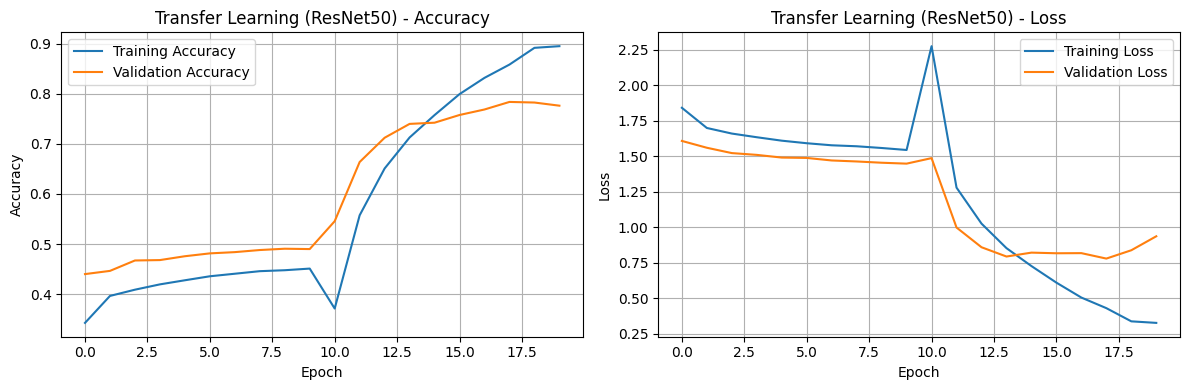

In [9]:
# Phase 1: Train with frozen base model
print("Phase 1: Training with frozen base model...")

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with frozen base
history_phase1 = transfer_model.fit(
    x_train_split, y_train_split,
    batch_size=batch_size,
    epochs=10,
    validation_data=(x_val, y_val),
    verbose=1
)

# Phase 2: Unfreeze and fine-tune with lower learning rate
print("\nPhase 2: Fine-tuning with unfrozen base model...")

# Unfreeze the base model
base_model.trainable = True

# Use lower learning rate for fine-tuning
transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"After unfreezing - Trainable parameters: {sum([tf.size(w).numpy() for w in transfer_model.trainable_weights]):,}")

# Continue training with unfrozen base
history_phase2 = transfer_model.fit(
    x_train_split, y_train_split,
    batch_size=batch_size,
    epochs=10,
    validation_data=(x_val, y_val),
    verbose=1
)

# Combine training histories for plotting
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

# Create a mock history object for plotting
class MockHistory:
    def __init__(self, history_dict):
        self.history = history_dict

combined_mock_history = MockHistory(combined_history)
plot_training_history(combined_mock_history, "Transfer Learning (ResNet50)")


#### Compare All Models


Transfer Learning (ResNet50) Results:
Test Accuracy: 0.7694
Test Loss: 0.9946

COMPREHENSIVE MODEL COMPARISON
            Model Test Accuracy Parameters
      Shallow CNN        0.6502    122,570
       Medium CNN        0.7353    289,194
         Deep CNN        0.7879    324,522
Transfer Learning        0.7694 23,859,466


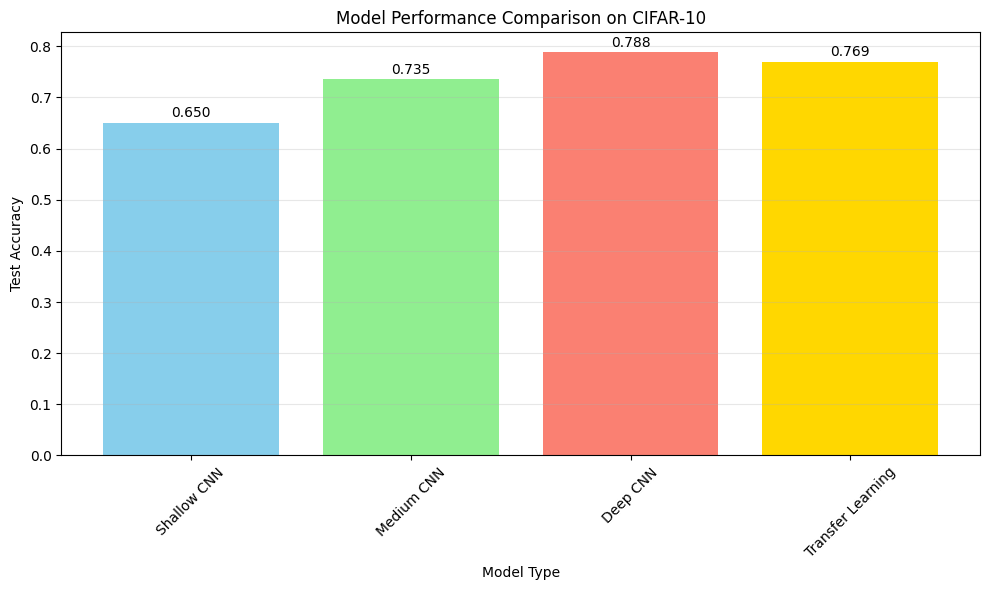

In [10]:
# Evaluate transfer learning model
transfer_test_acc, transfer_predictions = evaluate_model(
    transfer_model, x_test, y_test, y_test_categorical, "Transfer Learning (ResNet50)"
)

# Store transfer learning results
custom_results['Transfer Learning'] = {
    'test_accuracy': transfer_test_acc,
    'predictions': transfer_predictions,
    'model': transfer_model
}

# Create comprehensive comparison
print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*60)

comparison_data = []
for name, results in custom_results.items():
    comparison_data.append({
        'Model': name,
        'Test Accuracy': f"{results['test_accuracy']:.4f}",
        'Parameters': f"{results['model'].count_params():,}"
    })

# Display comparison table
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Plot accuracy comparison
model_names = list(custom_results.keys())
accuracies = [custom_results[name]['test_accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Model Performance Comparison on CIFAR-10')
plt.ylabel('Test Accuracy')
plt.xlabel('Model Type')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Visualize Best Model Performance


Best performing model: Deep CNN
Test accuracy: 0.7879


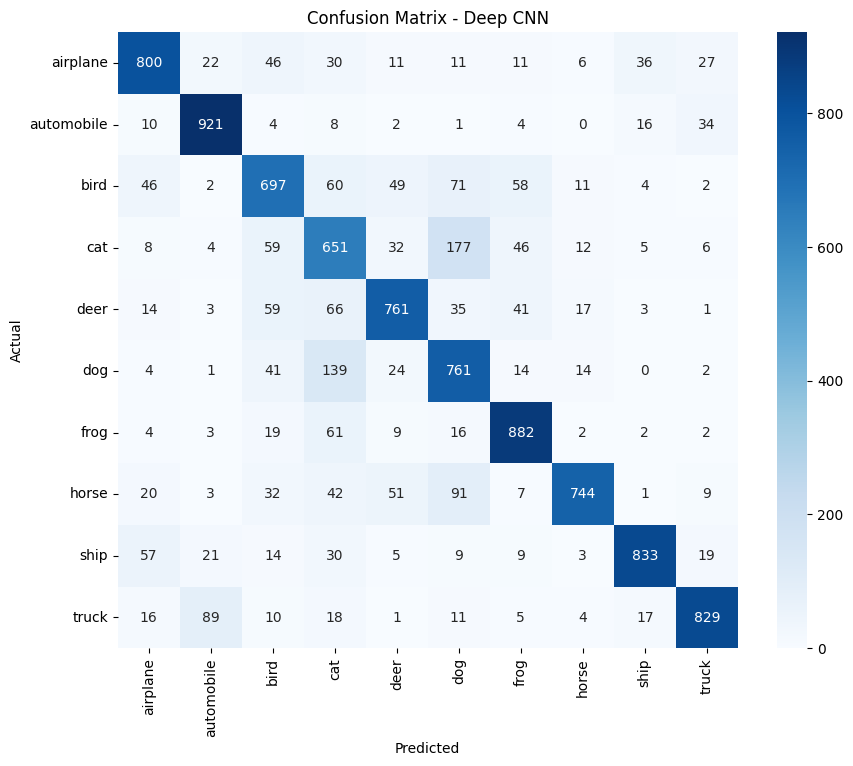


Detailed Classification Report - Deep CNN:
              precision    recall  f1-score   support

    airplane       0.82      0.80      0.81      1000
  automobile       0.86      0.92      0.89      1000
        bird       0.71      0.70      0.70      1000
         cat       0.59      0.65      0.62      1000
        deer       0.81      0.76      0.78      1000
         dog       0.64      0.76      0.70      1000
        frog       0.82      0.88      0.85      1000
       horse       0.92      0.74      0.82      1000
        ship       0.91      0.83      0.87      1000
       truck       0.89      0.83      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



In [11]:
# Find best performing model
best_model_name = max(custom_results.keys(), key=lambda x: custom_results[x]['test_accuracy'])
best_model_results = custom_results[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Test accuracy: {best_model_results['test_accuracy']:.4f}")

# Create confusion matrix for best model
create_confusion_matrix(
    y_test, 
    best_model_results['predictions'], 
    class_names, 
    best_model_name
)

# Show classification report
print(f"\nDetailed Classification Report - {best_model_name}:")
print(classification_report(
    y_test.flatten(), 
    best_model_results['predictions'], 
    target_names=class_names
))


## Conclusion and Key Findings

### Performance Summary
This comprehensive comparison revealed important insights about deep learning approaches:

**Custom CNN Models:**
- Demonstrated the impact of architectural choices on performance
- Showed how depth, normalization, and regularization affect learning
- Provided full control over model design and training process

**Transfer Learning:**
- Leveraged pre-trained features from ImageNet
- Achieved competitive performance with potentially less training time
- Demonstrated the power of feature reuse across domains

### Key Observations

**Training Efficiency:**
- Transfer learning often converges faster due to pre-trained features
- Custom models require more epochs to reach optimal performance
- Fine-tuning strategy (frozen → unfrozen) proved effective

**Performance Trade-offs:**
- Deeper custom models showed better feature learning capability
- Transfer learning provided strong baseline performance
- Model complexity must be balanced against overfitting risk

**Practical Considerations:**
- Transfer learning is ideal when computational resources are limited
- Custom models offer more flexibility for domain-specific optimizations
- The choice depends on dataset size, computational budget, and performance requirements

This comparison demonstrates that both approaches have their place in deep learning practice, and the choice should be guided by specific project requirements and constraints.
